In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Open words file
words = open('/content/drive/MyDrive/ML Learning/names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
# Vocabulary
chars = sorted(list(set(''.join(words))))
itos = {i+1:s for i, s in enumerate(chars)}
itos[0] = '.'
stoi = {s:i for i, s in itos.items()}
vocab_size = len(itos)

In [ ]:
# Building the dataset
block_size = 3

def build_dataset(words):
  X, Y = [],[]

  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# Splitting into train, dev, test
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtes, Ytes = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ----------> The Model <---------- #

In [ ]:
# Hyper parameters
n_embd = 5 # The size of the encoding for characters
n_hidden = 300 # The hidden layer size

# Parameters of the model
# Initialised using Kaiming initialisation
g = torch.Generator().manual_seed(2147836473)
C = torch.rand((vocab_size, n_embd),             generator=g)
w1 = torch.rand((n_embd * block_size, n_hidden), generator=g) * (5/3) * ((n_embd * block_size)**5)
b1 = torch.rand(n_hidden,                        generator=g) * 0.01
w2 = torch.rand((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.rand(vocab_size,                      generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, w1, b1, w2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # Number of params in model
for p in parameters:
  p.requires_grad = True

13662


In [ ]:
max_steps = 200000 # Number of training iterations
batch_size = 32
lossi = []

for i in range(max_steps):

  # Creating mini batches randomly
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # Forward Pass
  emb = C[Xtr[ix]] # Embedding the letters into vectors
  embcat = emb.view(emb.shape[0], -1) # concat the vectors to be 2d
  hpreact = embcat @ w1 + b1 # Hidden layer pre activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # Hidden layer
  logits = h @ w2 + b2 # Output layer
  loss = F.cross_entropy(logits, Ytr[ix]) # Loss Function

  # Backward pass
  for p in parameters: # Dont forget to reset the gradients to 0
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01 # learning rate decay
  for p in parameters:
      p.data += -lr * p.grad

  # Tracking stats
  if i % 10000 == 0: # printing only every now and then
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 2.7509
  10000/ 200000: 2.2863
  20000/ 200000: 2.2400
  30000/ 200000: 2.2961
  40000/ 200000: 1.7752
  50000/ 200000: 2.0333
  60000/ 200000: 2.1473
  70000/ 200000: 2.2330
  80000/ 200000: 1.9435
  90000/ 200000: 2.3555
 100000/ 200000: 2.6749
 110000/ 200000: 2.0748
 120000/ 200000: 2.3908
 130000/ 200000: 2.3154
 140000/ 200000: 2.0085
 150000/ 200000: 2.4258
 160000/ 200000: 2.1513
 170000/ 200000: 2.1082
 180000/ 200000: 2.0816
 190000/ 200000: 2.2531


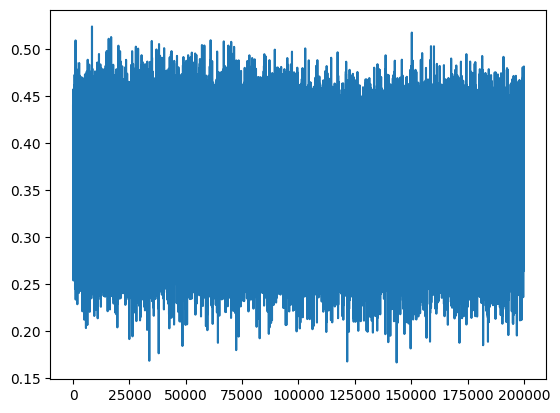

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xtes, Ytes)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ w1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.216773271560669
dev 2.225865364074707


In [ ]:
# Name generation

g = torch.Generator().manual_seed(42)

for _ in range(10):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ w1 + b1)
    logits = h @ w2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

aansdansvninqnilannnzmvaanndnnganvvvanvvninnnznndnaninvnisvnvninqsnnnznzasvaninsnpqnnnnzznndnsnanqninvninanglnvninvnnvzvansqnvansqvbsvavvaqnininnsnqsnnwnsiadnvaanvnndninanqnysnaanvninvninlninsainanaevmdqoainqaaninsanavninvnnnmninanqsbnnsannvvnanavninvnnqnznndnrnmmiiandvninlsqasliasnqvvnanqninanqnsninvninrnmznnsknndnznnsninvninsnanqsnsnanavninnnsnnnzninvnndnvmvanlvannvnnnznninvnnsnangznnvsvpnnnmnnznsnanqavnnnmandnznzninadnmdivgnncilavnsvnvnnanvvlaqavnindnvdnsnaqvntivpavvvannvilavsisnsnqnisnanavqnnqnavznndnanvvninvnnvsviaznsnqnilssnnnznaqnisannsknnmqansnaqamnilsnnwnnnvmnpnqsnninnnvvmanstsnnianmsisavnisvnvnnnznsnanqanncilanstnndnvnnvvannnvvlninasinnnvsantnnwnndnznnnvvlninvnnlnlainvnnzvnisnqsnvnnlninvnndvninnnvdnrnvmansnanqninassninnnnznnsnanqnnsvinadnsnanavqanwnnznninnnznanqannvsvnvnnnnzannnznnqannnzninqmnnznvanmgnnnsnangtwnnnznzannnvsqnvnnnvssnnqmvrnrnnvnndnisvnvnndnanqnanavqnnsnnwnnzntnndnqvvniniqnsanvvidnngnanqnnnznvilaqniniqqqdnnnznsnvnnnnnznndvninvnvninvninanginvnnnznzvndnqnininanysn

KeyboardInterrupt: ignored

In [ ]:
# The Pytorch Way

# Creating a linear layer
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trainined with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Forward Pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = self.running_var # batch variance
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalise to unit variance
    self.out = self.gamma * xhat + self.beta
    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momenum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
max_steps = 200000 # Number of training iterations
batch_size = 32
lossi = []

for i in range(max_steps):

  # Creating mini batches randomly
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # Forward Pass
  emb = C[Xb] # Embedding the letters into vectors
  x = emb.view(emb.shape[0], -1) # concat the vectors to be 2d
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # Loss function

  # Backward pass
  for layer in layers:
    layer.out.retain_grad() # Used for plotting the gradients
  for p in parameters: # Dont forget to reset the gradients to 0
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01 # learning rate decay
  for p in parameters:
      p.data += -lr * p.grad

  # Tracking stats
  if i % 10000 == 0: # printing only every now and then
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break # used for debugging

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

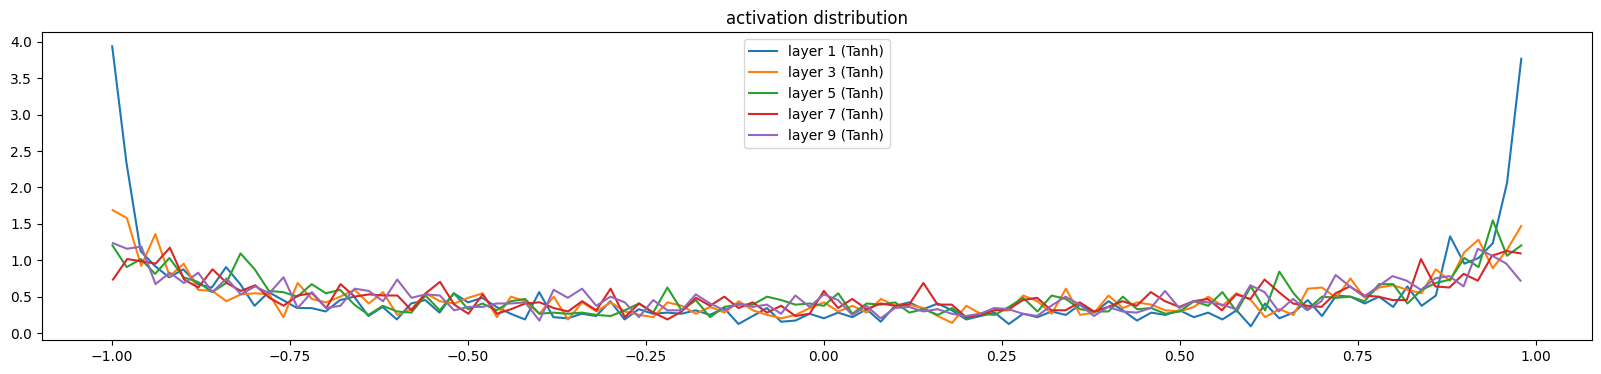

In [ ]:
# Visualising the activation inputs for each layer for one forward pass
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.00, std 0.00
layer 3 (      Tanh): mean -0.00, std 0.00
layer 5 (      Tanh): mean +0.00, std 0.00
layer 7 (      Tanh): mean +0.00, std 0.00
layer 9 (      Tanh): mean -0.00, std 0.00


Text(0.5, 1.0, 'gradient distribution')

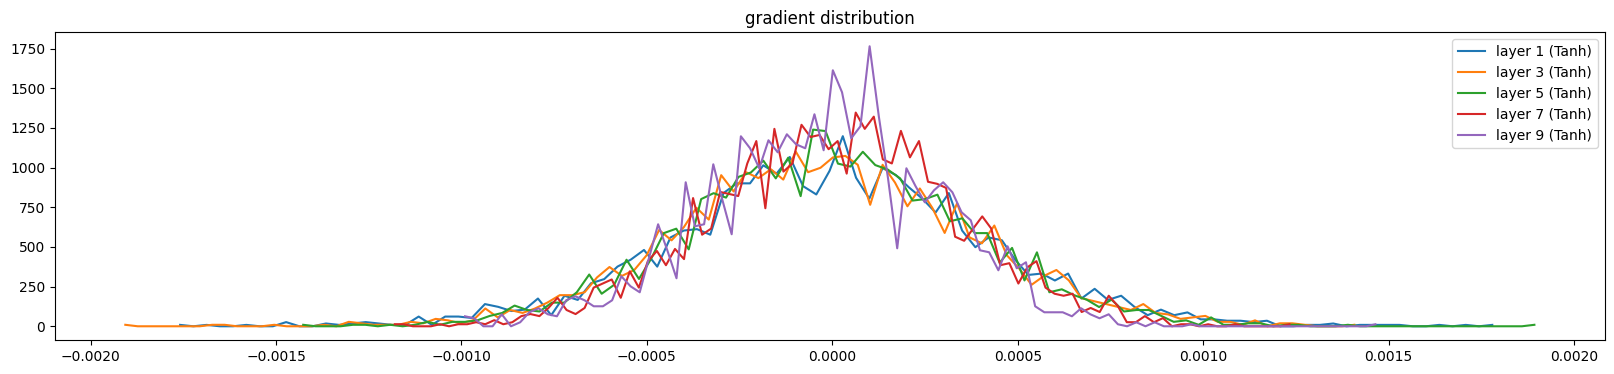

In [ ]:
# Visualising the gradient distributions of one backward pass at each layer
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')